# Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

# Utils

In [18]:
def data_preprocessing(data, product_availability, holidays_events_data, stores_data, oil_data):

    stores_data['country'] = 'Ecuador'

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'Regional']

    df1 = pd.merge(df_temp, stores_data, 
                left_on= 'locale_name',
                right_on=['state'], 
                how='left')

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'Local']
    df2 = pd.merge(df_temp, stores_data, 
                left_on= 'locale_name',
                right_on=['city'], 
                how='left')

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'National']
    df3 = pd.merge(df_temp, stores_data, 
                    how='left',
                    left_on= 'locale_name',
                    right_on=['country'])
    data_holiday = pd.concat([df1, df2, df3], ignore_index=True)

    data_holiday.rename(columns={"type_x": "holiday_type",
                    "type_y": "store_type"}, inplace=True)

    data_holiday.drop(columns=['description', 'locale', 
                    'locale_name', 'city','state','store_type','cluster','country' ], inplace=True)


    data = pd.merge(data, data_holiday, 
                on = ['date', 'store_nbr'], 
                how='left')

    data = pd.merge(data, stores_data,
                    on='store_nbr',
                    how='left')

    data = pd.merge(data, oil_data,
                    on='date',
                    how='left')
    
    data =pd.merge(data, product_availability,
                    on=['store_nbr', 'family'],
                    how='left')
    
    data.rename(columns={"sales_x": "sales"}, inplace=True)
    
    if 'sales_y' in data.columns:
        data.drop(columns=['sales_y'], inplace=True)
    else:
        data.drop(columns=['sales'], inplace=True)

    data = data.sort_values(by='date', ascending=True).reset_index(drop=True)
    data['is_wage_day'] = data['date'].apply(lambda x: True if x.day == 15 or x.day == x.days_in_month else False)

    data['dcoilwtico'] = data['dcoilwtico'].fillna(method='ffill')
    data['transferred'] = data['transferred'].fillna(False)
    data['is_holiday'] = ~data['holiday_type'].isna()
    data['day_of_week'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5, 6])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data.drop(columns=['country'], inplace=True)

    return data


def codificador(data):
    le = LabelEncoder()
    data['family'] = le.fit_transform(data['family'])
    data['type'] = le.fit_transform(data['type'])
    data['holiday_type'] = le.fit_transform(data['holiday_type'])
    data['city'] = le.fit_transform(data['city'])
    data['state'] = le.fit_transform(data['state'])
    data['is_wage_day'] = data['is_wage_day'].astype(int)
    data['is_weekend'] = data['is_weekend'].astype(int)
    data['is_sold'] = data['is_sold'].astype(int)
    data['is_holiday'] = data['is_holiday'].astype(int)
    data['transferred'] = data['transferred'].astype(int)
    return data

models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror')
]

def test_models(models, data_base:pd.DataFrame, cross_val=True):
    if 'date' in data_base.columns:
        data_base.drop(columns='date', inplace=True)
    if 'id' in data_base.columns:
        data_base.drop(columns='id', inplace=True)

    X = data_base.drop(columns=['sales'])
    y = data_base['sales']
    model_params = {}
    for model in models:
        if cross_val:
            scores = cross_val_score(model, 
                                     X, 
                                     y, 
                                     cv=5, 
                                     scoring='neg_mean_absolute_error', 
                                     n_jobs=-1)
            rmse_scores = np.sqrt(-scores)
            print(f"Model: {type(model).__name__}")
            print(f'RMSE Scores: {rmse_scores}')
            print(f'Mean RMSE: {rmse_scores.mean()}')
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print(f"Model: {type(model).__name__}")
            print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
            MSE = mean_squared_error(y_test, y_pred)
            RMSE = np.sqrt(MSE)
            print(f'MSE: {MSE}')
            print(f'RMSE: {RMSE}')
            model_params[type(model).__name__] = model
        print('-------------------------------------')
    return model_params

# Data loading and first impressions

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
stores_data = pd.read_csv('data/stores.csv')
oil_data = pd.read_csv('data/oil.csv')
holidays_events_data = pd.read_csv('data/holidays_events.csv')

product_availability = train_data.groupby(['store_nbr', 'family'])['sales'].sum().reset_index()
product_availability['is_sold'] = product_availability.groupby(['store_nbr', 
                                                                'family']
                                                                )['sales'].transform(
                                                                    lambda x: True 
                                                                    if x.sum() > 0 
                                                                    else False
                                                                )

train_data['date'] = pd.to_datetime(train_data['date'])
holidays_events_data['date'] = pd.to_datetime(holidays_events_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

oil_data['dcoilwtico'][0] = 93.14

print(train_data.head())
print(stores_data.head())
print(oil_data.head())
print(holidays_events_data.head())
print(product_availability.head())


   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
        date     type    locale locale_name   

# Data preprocessing

In [4]:
df = data_preprocessing(train_data, product_availability, holidays_events_data, stores_data, oil_data)
df_coded = codificador(df.copy())
display(df.head(5))
display(df_coded.head(5))

,id,date,store_nbr,family,sales,onpromotion,holiday_type,transferred,city,state,...,cluster,dcoilwtico,is_sold,is_wage_day,is_holiday,day_of_week,is_weekend,year,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,False,Quito,Pichincha,...,13,93.14,True,False,True,1,False,2013,1,1
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1
3,1192,2013-01-01,42,BOOKS,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1


,id,date,store_nbr,family,sales,onpromotion,holiday_type,transferred,city,state,...,cluster,dcoilwtico,is_sold,is_wage_day,is_holiday,day_of_week,is_weekend,year,month,day
0,0,2013-01-01,1,0,0.0,0,3,0,18,12,...,13,93.14,1,0,1,1,0,2013,1,1
1,1194,2013-01-01,42,6,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1
2,1193,2013-01-01,42,5,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1
3,1192,2013-01-01,42,4,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1
4,1191,2013-01-01,42,3,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1


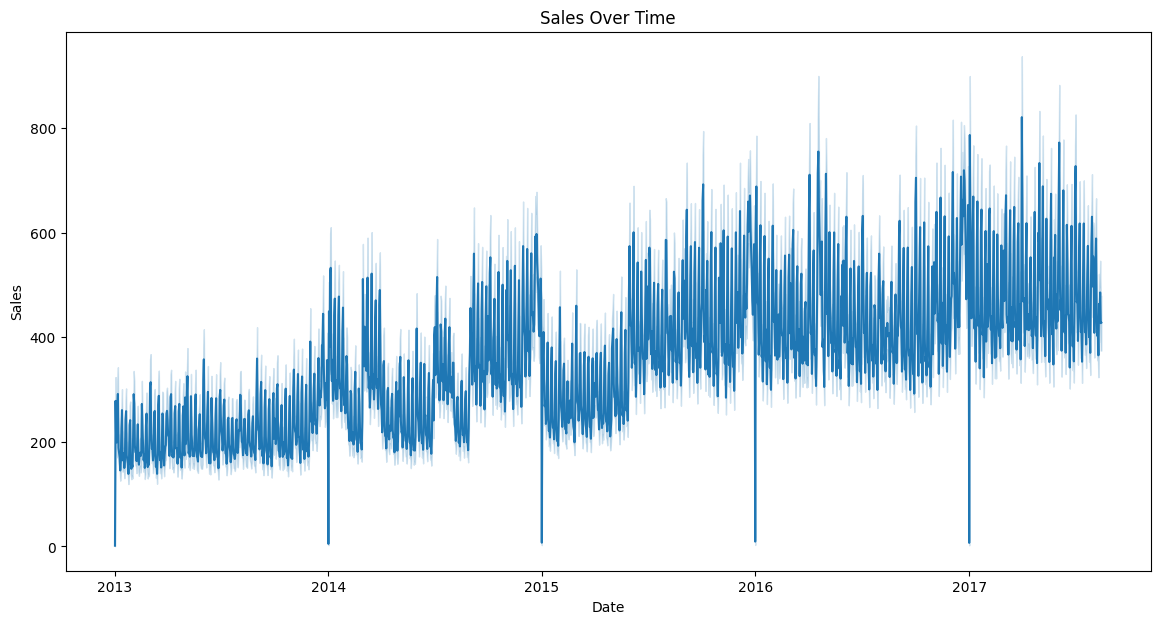

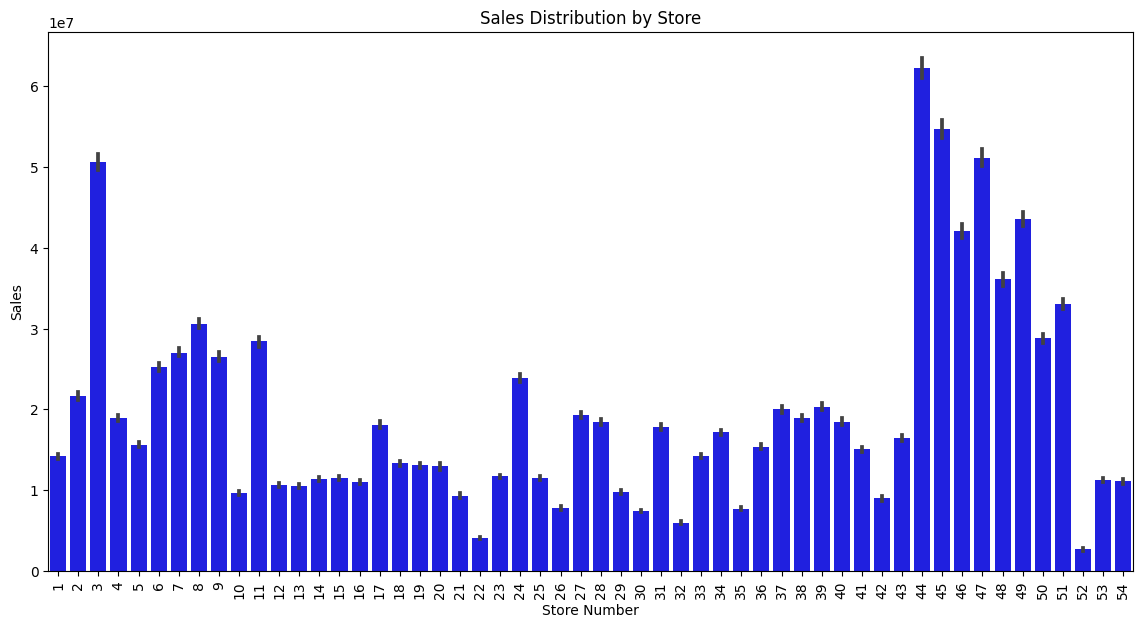

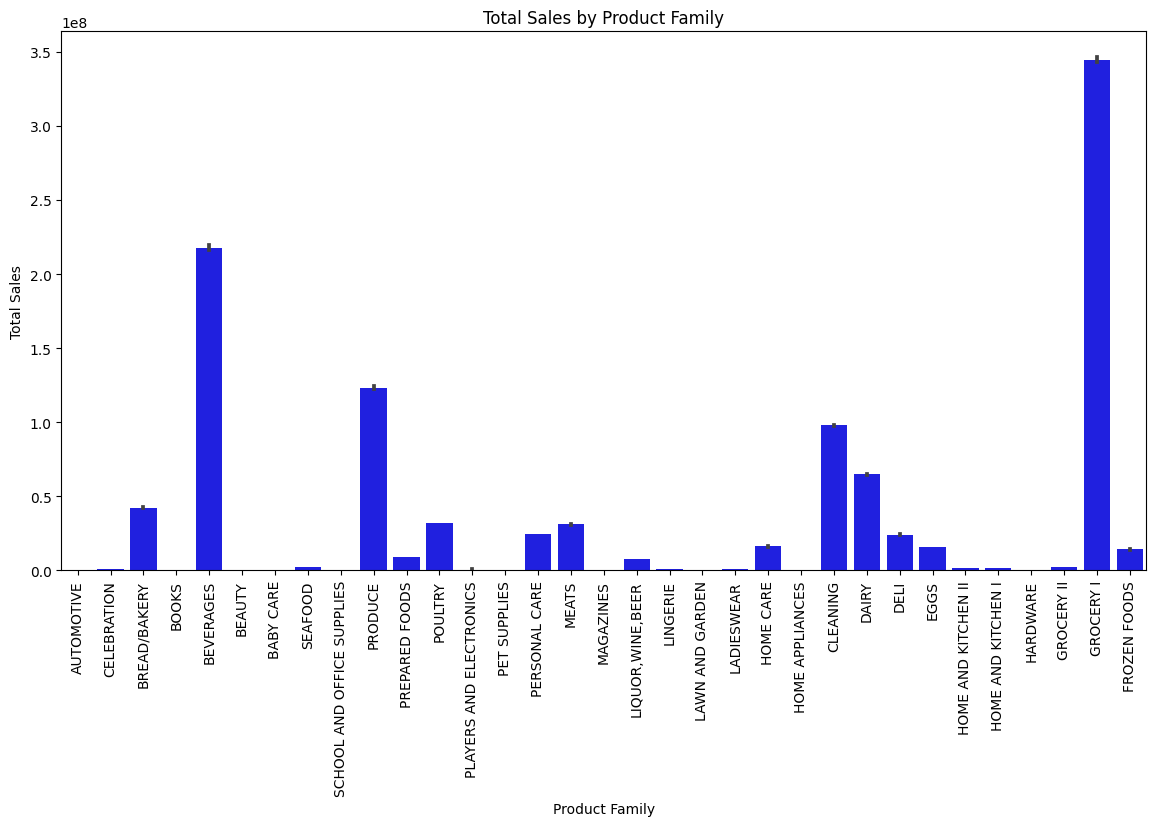

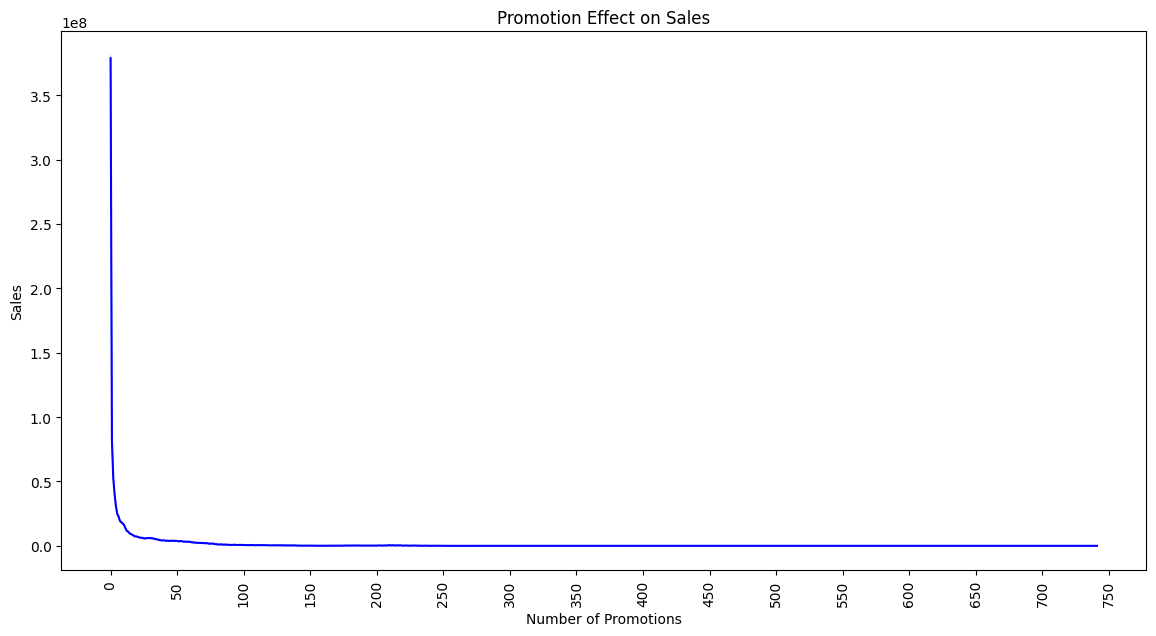

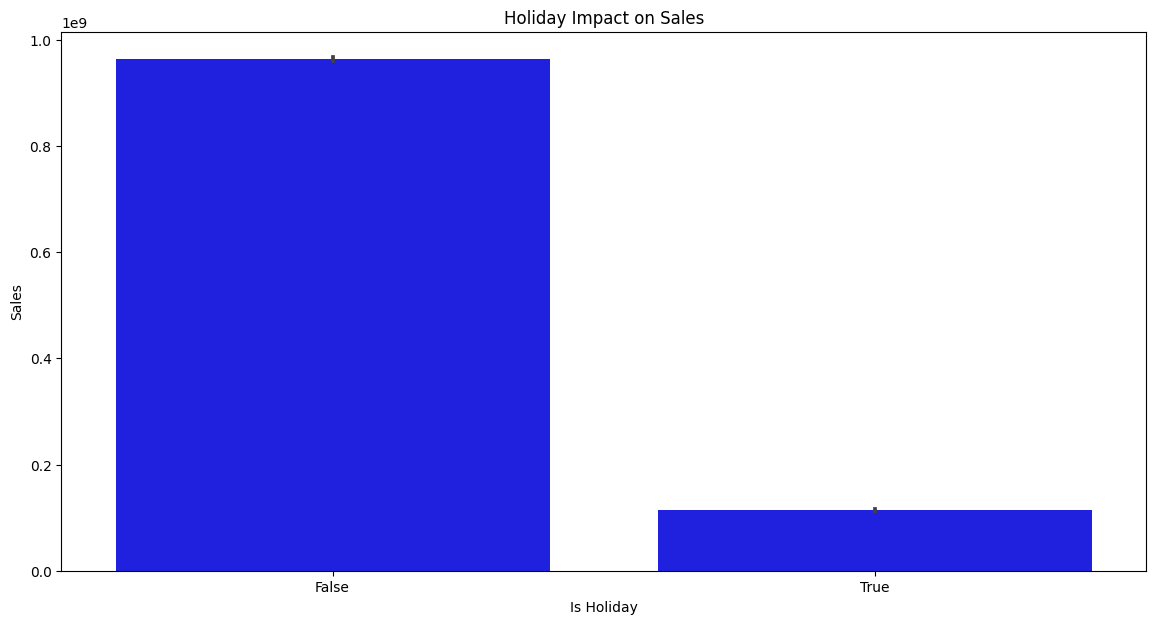

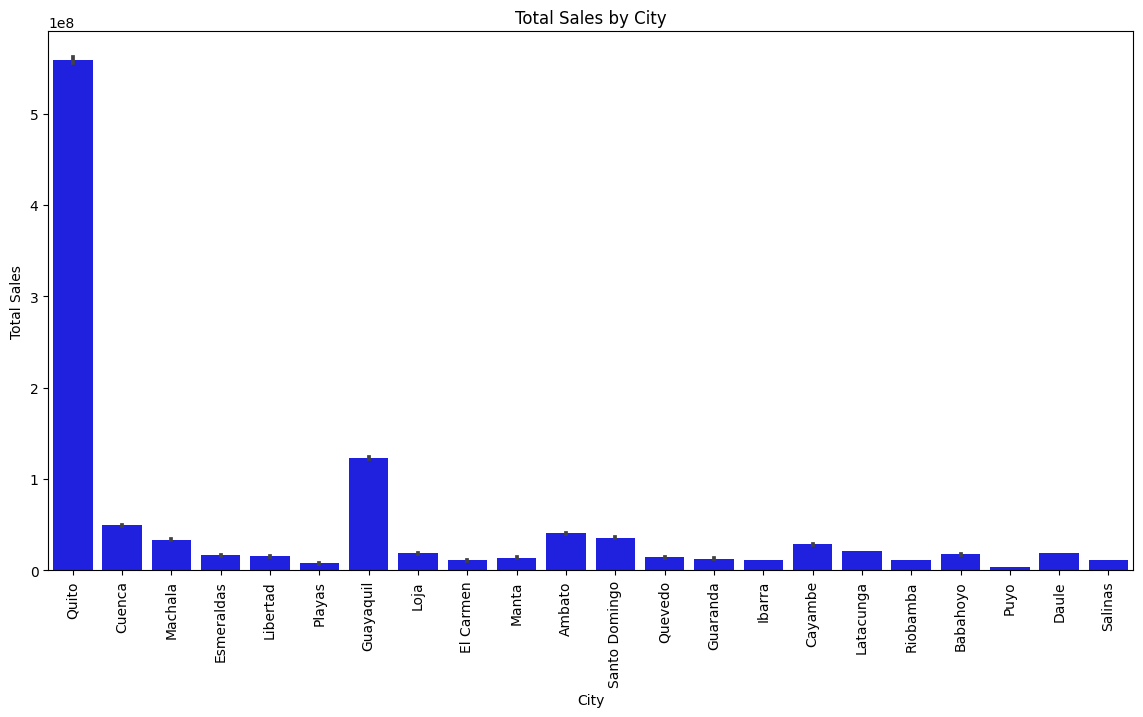

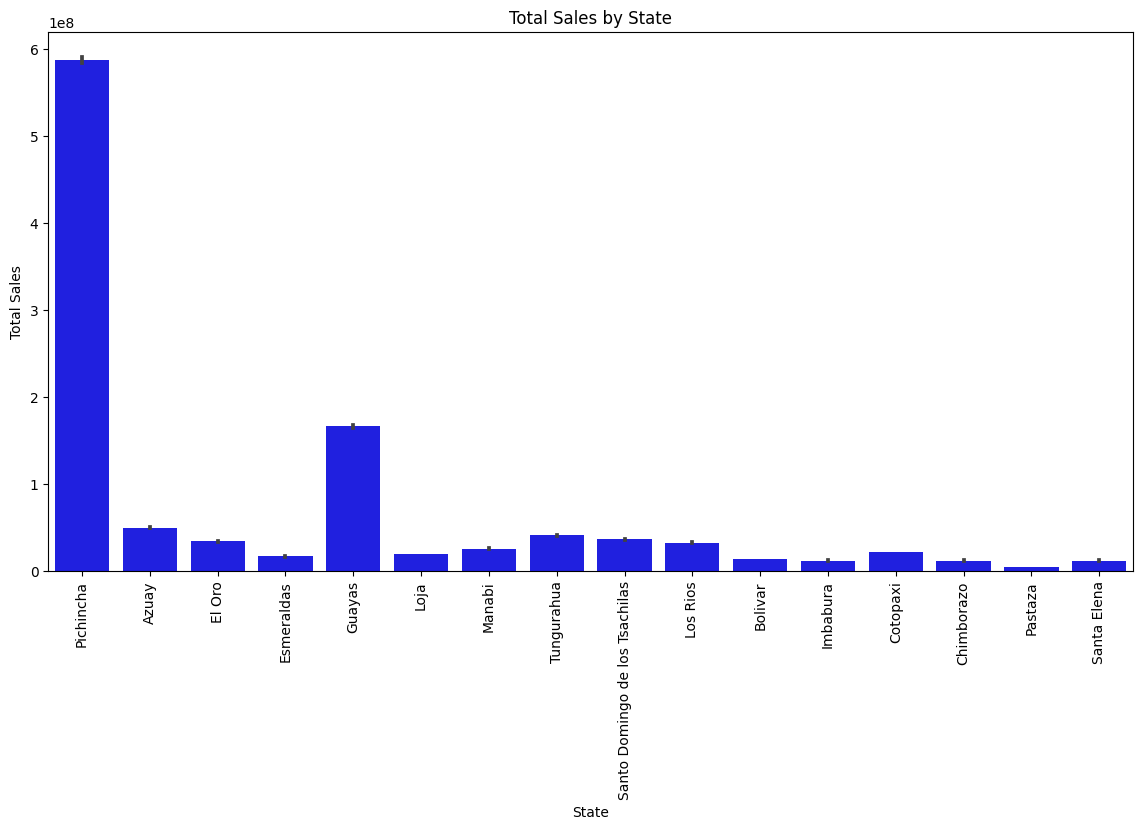

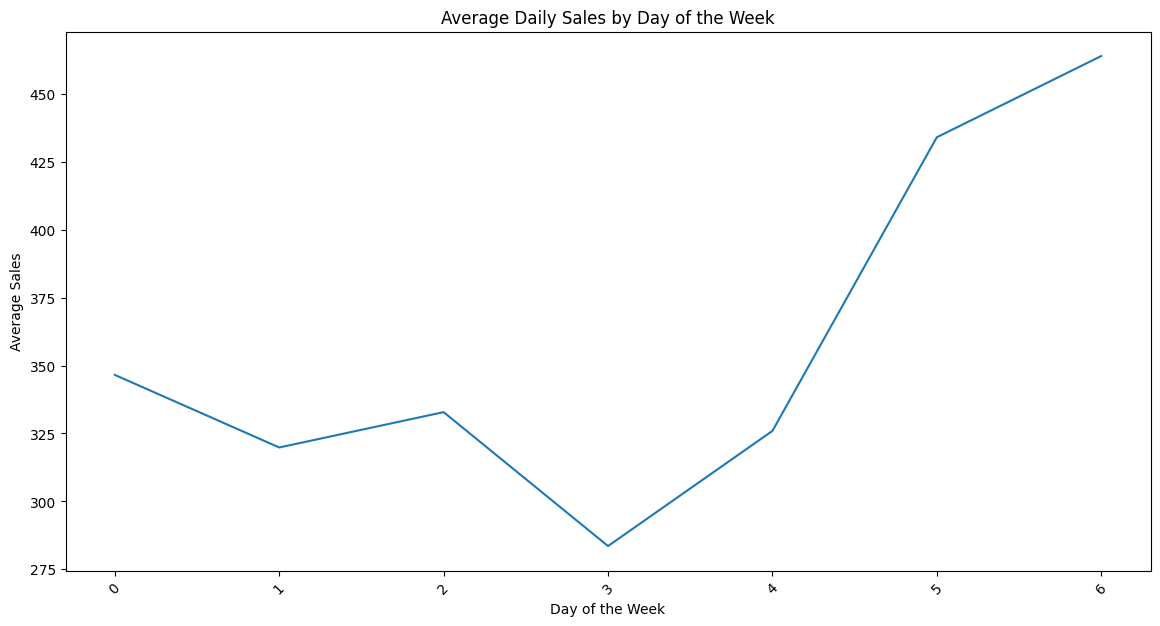

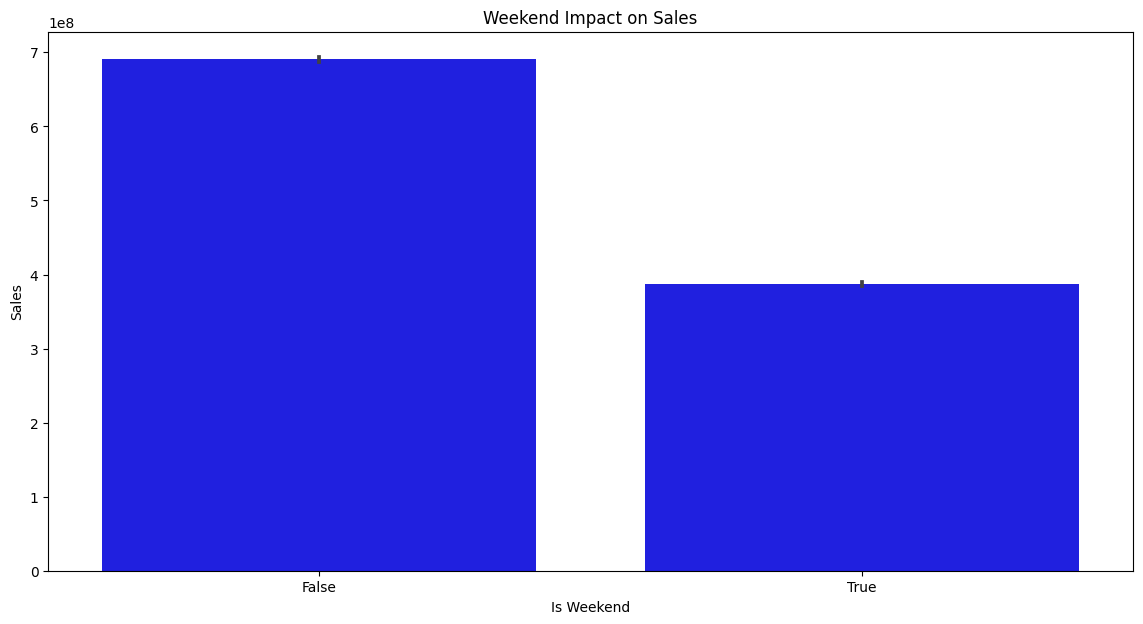

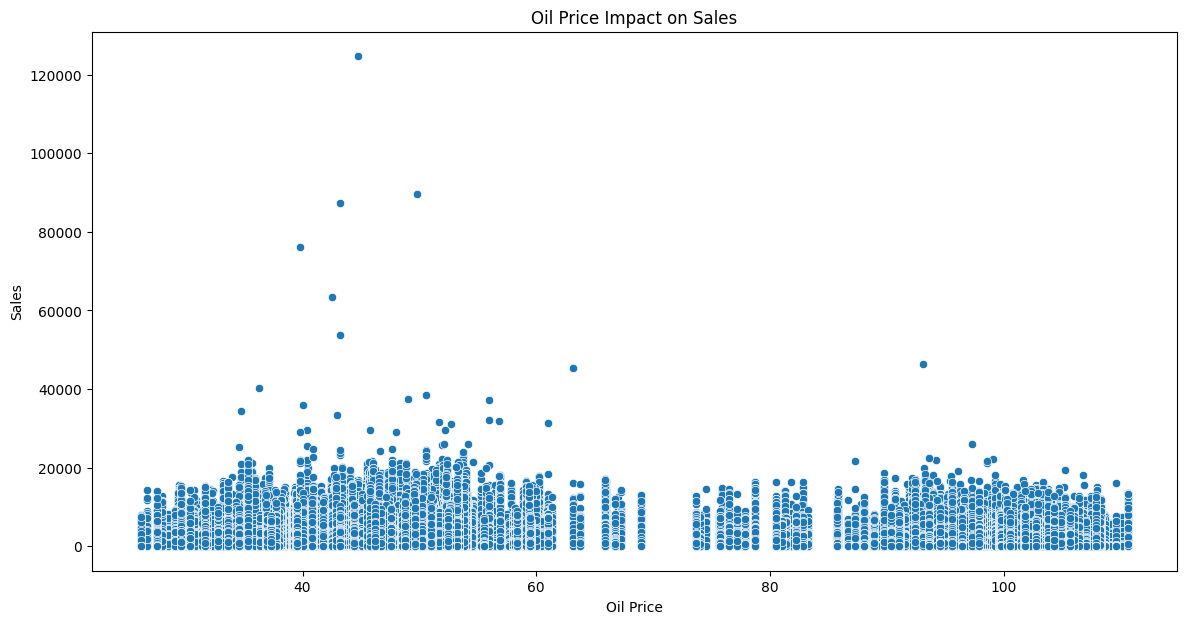

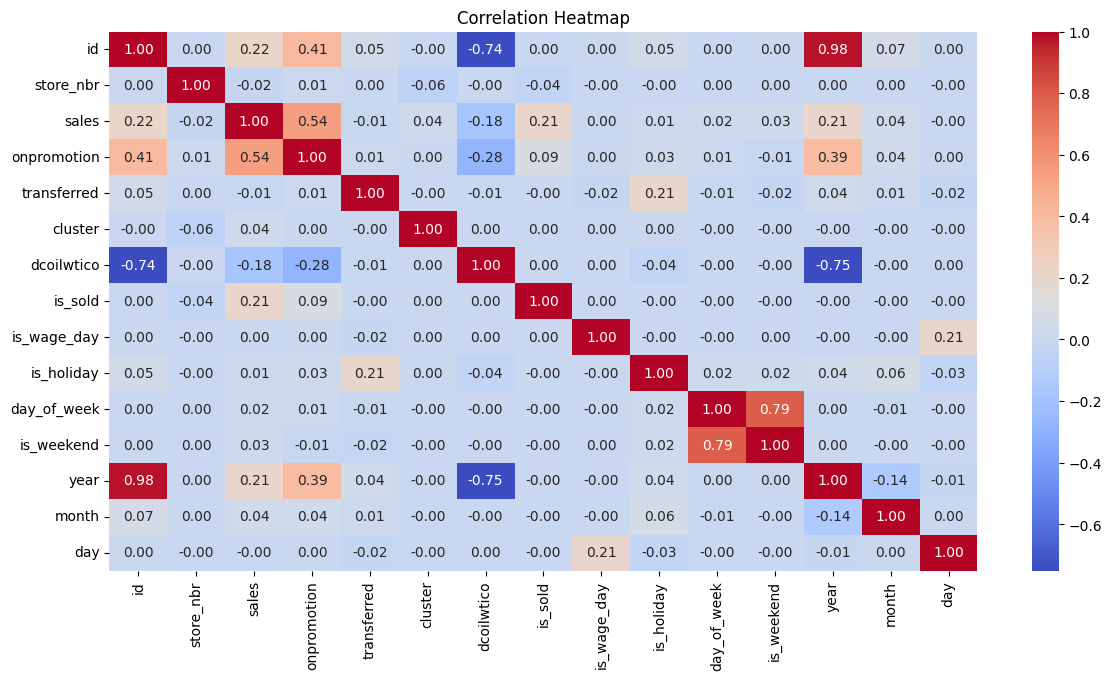

In [5]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='sales', data=df[['date', 'sales']])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.savefig(f"images/sales_over_time.png")
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='store_nbr', y='sales', data=df[['store_nbr', 'sales']], estimator=sum, color='blue')
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.savefig(f"images/sales_distribution_by_store.png")
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='family', y='sales', data=df[['family', 'sales']], estimator=sum, color='blue')
plt.title('Total Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.savefig(f"images/sales_by_product_family.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='onpromotion', y='sales', data=df[['onpromotion', 'sales']], estimator=sum, color='blue', ax=ax)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
plt.title('Promotion Effect on Sales')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.savefig(f"images/promotion_effect_on_sales.png")
plt.show()


plt.figure(figsize=(14, 7))
sns.barplot(x='is_holiday', y='sales', data=df[['is_holiday', 'sales']], estimator=sum, color='blue')
plt.title('Holiday Impact on Sales')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.savefig(f"images/holiday_impact_on_sales.png")
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='city', y='sales', data=df[['city','sales']], estimator=sum, color='blue')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.savefig(f"images/sales_by_city.png")
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='state', y='sales', data=df[['state','sales']], estimator=sum, color='blue')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.savefig(f"images/sales_by_state.png")
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(x='day_of_week', y='sales', data=df[['day_of_week','sales']], estimator='mean', ci=None)
plt.title('Average Daily Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.savefig(f"images/average_daily_sales_by_day_of_the_week.png")
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='is_weekend', y='sales', data=df[['is_weekend', 'sales']], estimator=sum, color='blue')
plt.title('Weekend Impact on Sales')
plt.xlabel('Is Weekend')
plt.ylabel('Sales')
plt.savefig(f"images/weekend_impact_on_sales.png")
plt.show()

plt.figure(figsize=(14, 7))
sns.scatterplot(x='dcoilwtico', y='sales', data=df[['dcoilwtico', 'sales']])
plt.title('Oil Price Impact on Sales')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.savefig(f"images/oil_price_impact_on_sales.png")
plt.show()

plt.figure(figsize=(14, 7))
corr = df.corr(numeric_only=True, method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig(f"images/correlation_heatmap.png")
plt.show()

## Observations

`Sales Over Time`: The trend indicates a general increase in sales over time, with noticeable spikes and dips, suggesting seasonal or periodic fluctuations. The sales seem to grow particularly from mid-2015 onwards, with higher peaks and increased volatility. Significant drops are evident at specific intervals, which might correspond to certain events or periods of low activity.

`Sales Distribution by Store`: The distribution implies that certain stores, possibly in better locations or with more effective management, outperform others by a considerable margin.

`Total Sales by Product Family`: The distribution suggests that staple goods like beverages and groceries are the most sold items, likely due to their frequent and essential nature.

`Promotion Effect on Sales`: This suggests that while promotions are effective initially, their effectiveness reduces over time or with quantity.

`Average Daily Sales by Day of the Week`: Sales are relatively stable from Sunday to Thursday, with a slight dip on Wednesday. However, there is a significant increase in sales on Friday and Saturday, peaking on Saturday. This pattern suggests that weekends are the most active sales days, possibly due to higher customer engagement during these days.

`Oil Price Impact on Sales`: There is a wide distribution of sales across various oil prices, but no clear linear relationship is visible. Sales are dispersed across different oil price levels, indicating that factors other than oil prices might have a more substantial impact on sales.

`Correlation Heatmap`: The correlation map shows that there is no input attribute of the model that has a very strong correlation with the target variable. However, it is observed that some attributes such as Onpromotion and is_sold may help the model.

# First prediction: the total sales of a Store

In [12]:
train1 = df_coded.drop(columns=['date','is_holiday', 'holiday_type', 'transferred', 
                               'is_holiday','dcoilwtico', 
                               'is_wage_day'])

display(train1.head(5))
train = train1[train1['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

test_models(models, train)

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,is_sold,day_of_week,is_weekend,year,month,day
0,0,1,0,0.0,0,18,12,3,13,1,1,0,2013,1,1
1,1194,42,6,0.0,0,3,0,3,2,1,1,0,2013,1,1
2,1193,42,5,0.0,0,3,0,3,2,1,1,0,2013,1,1
3,1192,42,4,0.0,0,3,0,3,2,1,1,0,2013,1,1
4,1191,42,3,0.0,0,3,0,3,2,1,1,0,2013,1,1


Model: DecisionTreeRegressor
RMSE Scores: [8.75669279 9.04837591 9.9925071  9.30012401 8.46779838]
Mean RMSE: 9.11309963726302
-------------------------------------
Model: RandomForestRegressor
RMSE Scores: [7.90498436 8.4384283  9.09237635 8.12717137 7.77510235]
Mean RMSE: 8.267612545529374
-------------------------------------
Model: XGBRegressor
RMSE Scores: [8.66379208 8.46532817 9.48379666 8.17541269 9.08335381]
Mean RMSE: 8.774336683421291
-------------------------------------


{}

## Adding holiday information

In [13]:
train2 = df_coded.drop(columns=['date','dcoilwtico', 'is_wage_day'])

display(train2.head(5))
train = train2[train2['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

test_models(models, train)

,id,store_nbr,family,sales,onpromotion,holiday_type,transferred,city,state,type,cluster,is_sold,is_holiday,day_of_week,is_weekend,year,month,day
0,0,1,0,0.0,0,3,0,18,12,3,13,1,1,1,0,2013,1,1
1,1194,42,6,0.0,0,3,0,3,0,3,2,1,1,1,0,2013,1,1
2,1193,42,5,0.0,0,3,0,3,0,3,2,1,1,1,0,2013,1,1
3,1192,42,4,0.0,0,3,0,3,0,3,2,1,1,1,0,2013,1,1
4,1191,42,3,0.0,0,3,0,3,0,3,2,1,1,1,0,2013,1,1


Model: DecisionTreeRegressor
RMSE Scores: [8.41528573 8.75483227 9.62420351 8.92760634 8.00320596]
Mean RMSE: 8.745026758667208
-------------------------------------
Model: RandomForestRegressor
RMSE Scores: [7.79849683 8.28080736 8.78178714 8.10344309 7.37619747]
Mean RMSE: 8.068146378903629
-------------------------------------
Model: XGBRegressor
RMSE Scores: [8.10407881 8.30688697 9.13918995 8.28532351 8.48814518]
Mean RMSE: 8.464724885234869
-------------------------------------


{}

## Adding oil barrel price information

In [14]:
train3 = df_coded.drop(columns=['date','is_wage_day'])

display(train3.head(5))
train = train3[train3['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

test_models(models, train)

,id,store_nbr,family,sales,onpromotion,holiday_type,transferred,city,state,type,cluster,dcoilwtico,is_sold,is_holiday,day_of_week,is_weekend,year,month,day
0,0,1,0,0.0,0,3,0,18,12,3,13,93.14,1,1,1,0,2013,1,1
1,1194,42,6,0.0,0,3,0,3,0,3,2,93.14,1,1,1,0,2013,1,1
2,1193,42,5,0.0,0,3,0,3,0,3,2,93.14,1,1,1,0,2013,1,1
3,1192,42,4,0.0,0,3,0,3,0,3,2,93.14,1,1,1,0,2013,1,1
4,1191,42,3,0.0,0,3,0,3,0,3,2,93.14,1,1,1,0,2013,1,1


Model: DecisionTreeRegressor
RMSE Scores: [9.77303235 8.77089655 9.85494055 9.12092278 8.69832713]
Mean RMSE: 9.243623871804344
-------------------------------------
Model: RandomForestRegressor
RMSE Scores: [9.29024899 8.25518039 8.79430086 8.09845962 7.85401885]
Mean RMSE: 8.458441742961922
-------------------------------------
Model: XGBRegressor
RMSE Scores: [8.94039125 8.46121525 9.08661677 8.36705713 8.90740459]
Mean RMSE: 8.752536999261014
-------------------------------------


{}

## Add public wages day

In [15]:
train4 = df_coded.drop(columns=['date'])

display(train4.head(5))
train = train4[train4['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

test_models(models, train)

,id,date,store_nbr,family,sales,onpromotion,holiday_type,transferred,city,state,...,cluster,dcoilwtico,is_sold,is_wage_day,is_holiday,day_of_week,is_weekend,year,month,day
0,0,2013-01-01,1,0,0.0,0,3,0,18,12,...,13,93.14,1,0,1,1,0,2013,1,1
1,1194,2013-01-01,42,6,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1
2,1193,2013-01-01,42,5,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1
3,1192,2013-01-01,42,4,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1
4,1191,2013-01-01,42,3,0.0,0,3,0,3,0,...,2,93.14,1,0,1,1,0,2013,1,1


Model: DecisionTreeRegressor
RMSE Scores: [9.82730575 8.86596303 9.84863661 9.06950181 8.59503125]
Mean RMSE: 9.241287689476795
-------------------------------------
Model: RandomForestRegressor
RMSE Scores: [9.33697498 8.15902995 8.84169006 8.12456825 7.89053396]
Mean RMSE: 8.470559439320736
-------------------------------------
Model: XGBRegressor
RMSE Scores: [9.19612962 8.6074857  9.09807848 8.21923014 8.79013236]
Mean RMSE: 8.78221125701182
-------------------------------------


{}

# Predicting sales for all stores

In [44]:
submission = data_preprocessing(test_data, product_availability, holidays_events_data, stores_data, oil_data)
submission = submission.sort_values(by='id', ascending=True).reset_index(drop=True)
submission = codificador(submission)

In [45]:
for train, train_name in [(train1, "base_train1"), (train2, "base_train2"), (train3, "base_train3"), (train4,"base_train4")]:
    print(f"Training {train_name}")
    model_params = test_models(models, train, cross_val=False)
    for model in model_params:
        X_submission = submission[train.drop(columns=['sales']).columns]
        y_submission = model_params[model].predict(X_submission)
        submission_file = pd.DataFrame({'id': submission['id'], 'sales': y_submission})
        submission_file.to_csv(f'results/{train_name}_{model}.csv', index=False)

Training base_train1
Model: DecisionTreeRegressor
MAE: 62.58550951718024
MSE: 148065.74744506838
RMSE: 384.79312291810567
-------------------------------------
Model: RandomForestRegressor
MAE: 47.29377558838639
MSE: 61508.93662143009
RMSE: 248.00995266607768
-------------------------------------
Model: XGBRegressor
MAE: 115.82823466008226
MSE: 103350.21754776554
RMSE: 321.481286465893
-------------------------------------
Training base_train2
Model: DecisionTreeRegressor
MAE: 60.94361306935017
MSE: 96225.67931709497
RMSE: 310.20264234383137
-------------------------------------
Model: RandomForestRegressor
MAE: 46.51031673633116
MSE: 59469.05325038647
RMSE: 243.86277545042924
-------------------------------------
Model: XGBRegressor
MAE: 117.14635776556769
MSE: 105596.56967673094
RMSE: 324.95625809750294
-------------------------------------
Training base_train3
Model: DecisionTreeRegressor
MAE: 61.711720983702016
MSE: 109198.7172171467
RMSE: 330.4522918927129
------------------------

# Kaggle submission

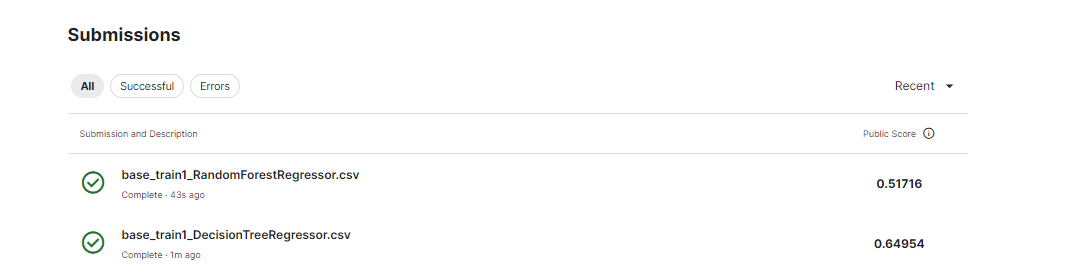

In [47]:
Image(filename='images/kaggle-sales-submission.png')

# Conclusion

In this notebook, we aimed to predict the target value using various machine learning models. After testing multiple models with multiple datasets, the best results were achieved with the **data_base1** and  the **RandomForestRegressor**.

### Model Performance

- **Mean Absolute Error (MAE):** 47.29
- **Mean Squared Error (MSE):** 61508.94
- **Root Mean Squared Error (RMSE):** 248.01

### Model Performance on Kaggle
**Score:** 0.51716